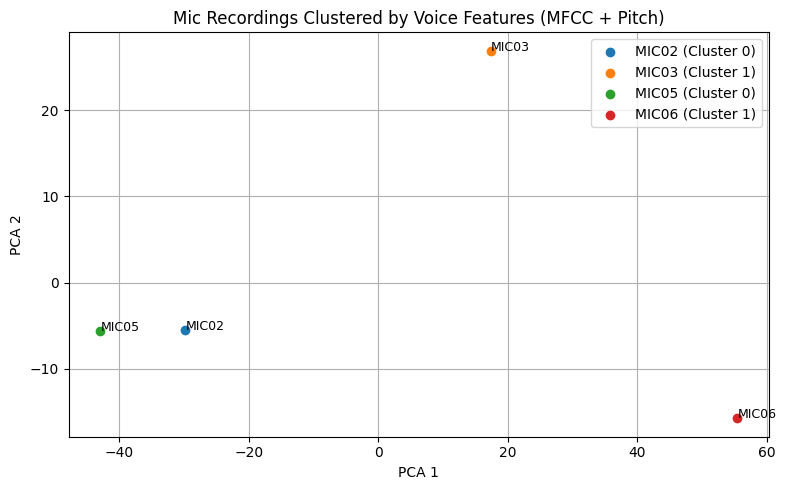

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# === FILE PATHS ===
mic_2 = r"D:\software project\Software-project\recordings\BMI_UK17100322_cherkasy_ositna\BMI_UK17100322_cherkasy_ositna_MIC02.mp3"
mic_3 = r"D:\software project\Software-project\recordings\BMI_UK17100322_cherkasy_ositna\BMI_UK17100322_cherkasy_ositna_MIC03.mp3"
mic_5 = r"D:\software project\Software-project\recordings\BMI_UK17100322_cherkasy_ositna\BMI_UK17100322_cherkasy_ositna_MIC05.mp3"
mic_6 = r"D:\software project\Software-project\recordings\BMI_UK17100322_cherkasy_ositna\BMI_UK17100322_cherkasy_ositna_MIC06.mp3"

mic_files = [mic_2, mic_3, mic_5, mic_6]
mic_names = ["MIC02", "MIC03", "MIC05", "MIC06"]

# === FEATURE EXTRACTION FUNCTION ===
def extract_features(filename):
    y, sr = librosa.load(filename, sr=None)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Pitch (f0) using pYIN
    f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'),
                               fmax=librosa.note_to_hz('C6'))

    # Clean unvoiced frames
    f0_clean = f0[~np.isnan(f0)]

    # Pitch stats
    if len(f0_clean) > 0:
        midi_mean = np.mean(librosa.hz_to_midi(f0_clean))
        midi_var = np.var(librosa.hz_to_midi(f0_clean))
    else:
        midi_mean = 0
        midi_var = 0

    return np.concatenate([mfccs_mean, [midi_mean, midi_var]])

# === EXTRACT FEATURES FROM EACH MIC ===
features = [extract_features(f) for f in mic_files]

# === CLUSTERING ===
kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(features)

# === PCA FOR VISUALIZATION ===
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# === PLOT RESULTS ===
plt.figure(figsize=(8, 5))
for i, (x, y) in enumerate(features_pca):
    plt.scatter(x, y, label=f"{mic_names[i]} (Cluster {labels[i]})")
    plt.text(x + 0.01, y + 0.01, mic_names[i], fontsize=9)

plt.title("Mic Recordings Clustered by Voice Features (MFCC + Pitch)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


DTW Distance Matrix (lower = more similar):

       MIC02   MIC03   MIC05   MIC06
MIC02        0    8315    9021   12987
MIC03     8315       0   10522   12815
MIC05     9021   10522       0   14001
MIC06    12987   12815   14001       0


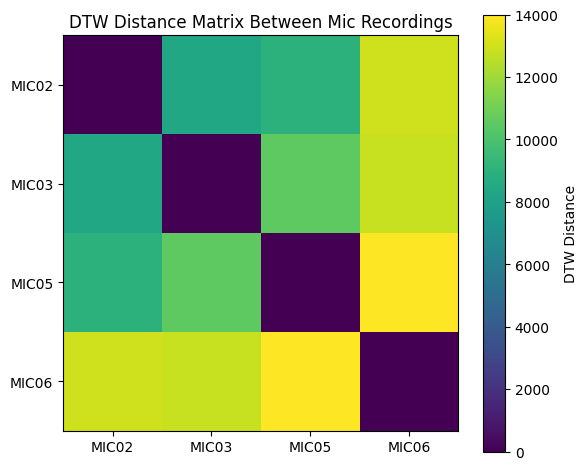

In [5]:
import librosa
import numpy as np
from librosa.sequence import dtw
import itertools
import matplotlib.pyplot as plt

# Mic file paths and labels
mic_files = {
    "MIC02": mic_2,
    "MIC03": mic_3,
    "MIC05": mic_5,
    "MIC06": mic_6,
}

# Extract MFCCs for all
def extract_mfcc(y, sr):
    return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

mfcc_data = {}
for name, path in mic_files.items():
    y, sr = librosa.load(path)
    mfcc = extract_mfcc(y, sr)
    mfcc_data[name] = mfcc.T  # Transpose for DTW

# Compute DTW distances
mic_names = list(mic_files.keys())
n = len(mic_names)
distance_matrix = np.zeros((n, n))

for i, j in itertools.combinations(range(n), 2):
    name_i, name_j = mic_names[i], mic_names[j]
    D, _ = dtw(X=mfcc_data[name_i], Y=mfcc_data[name_j], metric='euclidean')
    distance = D[-1, -1]
    distance_matrix[i, j] = distance
    distance_matrix[j, i] = distance

# Print matrix nicely
print("DTW Distance Matrix (lower = more similar):\n")
print("      " + "  ".join(f"{name:>6}" for name in mic_names))
for i, name in enumerate(mic_names):
    row = "  ".join(f"{distance_matrix[i, j]:6.0f}" for j in range(n))
    print(f"{name:<6}  {row}")

# Optional: Plot heatmap
plt.figure(figsize=(6, 5))
plt.imshow(distance_matrix, interpolation='nearest', cmap='viridis')
plt.xticks(ticks=range(n), labels=mic_names)
plt.yticks(ticks=range(n), labels=mic_names)
plt.colorbar(label='DTW Distance')
plt.title("DTW Distance Matrix Between Mic Recordings")
plt.tight_layout()
plt.show()
